# Phys. Rev. Lett. **111**, 103603 - Plots

## Imports

In [1]:
# dependencies
import numpy as np
import scipy.constants as sc

# qom v0.7.0 modules
from qom.loopers import XLooper
from qom.systems import DODMSystem
from qom.ui import init_log
from qom.ui.plotters import MPLPlotter

# initialize log
init_log()

MainProcess              INFO    2021-05-18 10:32:27.194: (qom.ui.log) ------------------------------Logger Initialized-----------------


## The System Class

In [2]:
class System(DODMSystem):
    """Class to simulate the QOM system in PhysRevLett.111.103605.

    Parameters
    ----------
    params : dict
        Parameters for the system.
    """

    def __init__(self, params):
        """Class constructor for System."""
        
        # initialize super class
        super().__init__(params)

        # update code and name
        self.code = 'system'
        self.name = 'Coupled QOM System'
        # default parameters
        self.params = {
            'E': params.get('E', 320),
            'g': params.get('g', 0.005),
            'gamma': params.get('gamma', 0.005),
            'kappa': params.get('kappa', 0.15),
            'mu': params.get('mu', 0.02),
            'n_b': params.get('n_b', 0),
            'omega_1': params.get('omega_1', 1),
            'omega_2': params.get('omega_2', 1.005)
        }
        # matrices
        self.A = None
        self.D = None

    def get_A(self, modes):
        """Function to obtain the drift matrix.

        Parameters
        ----------
        modes : list
            Values of the optical and mechancial modes.
        
        Returns
        -------
        A : list
            Drift matrix.
        """

        # extract frequently used variables
        g           = self.params['g']
        gamma       = self.params['gamma']
        kappa       = self.params['kappa']
        mu          = self.params['mu']
        alphas      = [modes[0], modes[2]]
        betas       = [modes[1], modes[3]]

        # get frequencies 
        Delta_0s, omegas = self.get_frequencies()

        # time frame
        tau = 2 * np.pi / omegas[0]

        # effective values
        Deltas = list()
        Gs = list()
        for i in range(2):
            Deltas.append(Delta_0s[i] + 2 * g * np.real(betas[i]))
            Gs.append(g * alphas[i])

        # initialize drift matrix
        if self.A is None or np.shape(self.A) != (8, 8):
            self.A = np.zeros([8, 8], dtype=np.float_)
        for i in range(2):
            # optical position quadrature
            self.A[4 * i + 0][4 * i + 0] = - kappa
            self.A[4 * i + 0][4 * i + 1] = - Deltas[i]
            self.A[4 * i + 0][4 * i + 2] = - 2 * np.imag(Gs[i])
            # optical momentum quadrature
            self.A[4 * i + 1][4 * i + 0] = Deltas[i]
            self.A[4 * i + 1][4 * i + 1] = - kappa
            self.A[4 * i + 1][4 * i + 2] = 2 * np.real(Gs[i])
            # mechanical position quadrature
            self.A[4 * i + 2][4 * i + 2] = - gamma
            self.A[4 * i + 2][4 * i + 3] = omegas[i]
            self.A[4 * i + 2][4 * (1 - i) + 3] = - mu
            # mechanical momentum quadrature
            self.A[4 * i + 3][4 * i + 0] = 2 * np.real(Gs[i])
            self.A[4 * i + 3][4 * i + 1] = 2 * np.imag(Gs[i])
            self.A[4 * i + 3][4 * i + 2] = - omegas[i]
            self.A[4 * i + 3][4 * i + 3] = - gamma
            self.A[4 * i + 3][4 * (1 - i) + 2] = mu

        return self.A * tau

    def get_D(self):
        """Function to obtain the noise correlation matrix.
        
        Returns
        -------
        D : list
            Noise correlation matrix.
        """

        # extract frequently used variables
        gamma       = self.params['gamma']
        kappa       = self.params['kappa']
        n_b         = self.params['n_b']

        # get frequencies 
        _, omegas = self.get_frequencies()

        # time frame
        tau = 2 * np.pi / omegas[0]

        # noise correlation matrix
        if self.D is None or np.shape(self.D) != (8, 8):
            self.D = np.zeros([8, 8], dtype=np.float_)
        for i in range(2):
            self.D[4* i + 0][4* i + 0] = kappa
            self.D[4* i + 1][4* i + 1] = kappa
            self.D[4* i + 2][4* i + 2] = gamma * (2 * n_b + 1)
            self.D[4* i + 3][4* i + 3] = gamma * (2 * n_b + 1)

        return self.D * tau

    def get_frequencies(self):
        """Function to obtain the various frequencies.
        
        Returns
        -------
        Delta_0s : float
            Laser detunings.
        omegas : float
            Mechanical frequencies.
        """
        
        # extract frequently used variables
        omega_1     = self.params['omega_1']
        omega_2     = self.params['omega_2']

        # laser detunings
        Delta_0s = [omega_1, omega_2]
        # mechanical frequencies
        omegas = [omega_1, omega_2]

        return Delta_0s, omegas

    def get_rates_modes(self, modes):
        """Function to obtain the rates of the optical and mechanical modes.

        Parameters
        ----------
        modes : list
            Values of the modes.
        
        Returns
        -------
        mode_rates : list
            Rates for each mode.
        """

        # extract frequently used variables
        E           = self.params['E']
        g           = self.params['g']
        gamma       = self.params['gamma']
        kappa       = self.params['kappa']
        mu          = self.params['mu']
        alphas      = [modes[0], modes[2]]
        betas       = [modes[1], modes[3]]

        # get frequencies
        Delta_0s, omegas = self.get_frequencies()

        # time frame
        tau = 2 * np.pi / omegas[0]

        # effective values
        Deltas = list()
        Gs = list()
        for i in range(2):
            Deltas.append(Delta_0s[i] + 2 * g * np.real(betas[i]))
            Gs.append(g * alphas[i])

        # calculate rates
        dalpha_dts = list()
        dbeta_dts = list()
        for i in range(2):
            dalpha_dts.append(((- kappa + 1j * Deltas[i]) * alphas[i] + E * kappa))
            dbeta_dts.append((1j * Gs[i] * np.conjugate(alphas[i]) + (- gamma - 1j * omegas[i]) * betas[i] + 1j * mu * betas[1 - i]))

        # rearrange rates
        mode_rates = [dalpha_dts[0] * tau, dbeta_dts[0] * tau, dalpha_dts[1] * tau, dbeta_dts[1] * tau]

        return mode_rates

    def ivc_func(self):
        """Function to obtain the initial values and constants required for the IVP.
        
        Returns
        -------
        iv : list
            Initial values of variables.

        c : list
            Constant parameters.
        """

        # extract frequently used variables
        n_b         = self.params['n_b']
 
        # initial mode values as 1D list
        u_0 = np.zeros(4, dtype=np.complex_).tolist()

        # initial quadrature correlations
        V_0 = np.zeros([8, 8], dtype=np.float_)
        for i in range(2):
            V_0[4* i + 0][4* i + 0] = 1/2
            V_0[4* i + 1][4* i + 1] = 1/2
            V_0[4* i + 2][4* i + 2] = (n_b + 1/2)
            V_0[4* i + 3][4* i + 3] = (n_b + 1/2)

        # convert to 1D list and concatenate all variables
        iv = u_0 + [np.complex(element) for element in V_0.flatten().tolist()]

        return iv, None

    def ode_func(self, t, v):
        """Function for the rate equations of the modes and quadrature correlations.
        
        The variables are complex-valued, hence the model requires a complex-valued integrator.
        
        Parameters
        ----------
        t : *float*
            Time at which the rate is calculated.

        v : list
            Complex-valued variables defining the system. 
            First 2 elements contain the optical and mechanical modes of the 1st cavity.
            Next 2 elements contain the optical and mechanical modes of the 2nd cavity.
            Next (4*2)^2 elements contain the correlations.

        Returns
        -------
        rates : list
            Rates of the complex-valued variables defining the system. 
            First 2 elements contain the optical and mechanical modes of the 1st cavity.
            Next 2 elements contain the optical and mechanical modes of the 2nd cavity.
            Next (4*2)^2 elements contain the correlations.
        """
        
        # extract the modes and correlations
        modes   = v[0:4]
        corrs   = np.real(v[4:]).reshape([8, 8])

        # mode rates
        mode_rates  = self.get_rates_modes(modes)

        # drift matrix
        A = self.get_A(modes)
        # noise matrix
        D = self.get_D()

        # quadrature correlation rate equation
        dcorrs_dt = A.dot(corrs) + corrs.dot(np.transpose(A)) + D

        # mirror matrix
        for i in range(len(dcorrs_dt)):
            for j in range(0, i):
                dcorrs_dt[i, j] = dcorrs_dt[j, i]

        # convert to 1D list and concatenate all rates
        rates = mode_rates + [np.complex(element) for element in dcorrs_dt.flatten()]

        return rates

## Scripts

### Utility Functions

In [3]:
# function to calculate average measure
def func_measure_average(system_params, val, logger, results):
    # update parameters
    system.params = system_params
    # get measures
    M = system.get_measure_dynamics(params['solver'], system.ode_func, system.ivc_func)
    # calculate average
    m_avg = np.mean(M)
    # update results
    results.append((val, m_avg)) 

### Figure 2a

MainProcess              INFO    2021-05-18 10:32:27.346: (qom.solvers.HLESolver) -------------------Results Loaded---------------------
MainProcess              INFO    2021-05-18 10:32:27.428: (qom.systems.BaseSystem) ------------------Obtaining Measures-----------------
MainProcess              INFO    2021-05-18 10:32:27.551: (qom.systems.BaseSystem) ------------------Measures Obtained------------------
MainProcess              INFO    2021-05-18 10:32:27.623: (qom.solvers.HLESolver) -------------------Results Loaded---------------------
MainProcess              INFO    2021-05-18 10:32:27.759: (qom.systems.BaseSystem) ------------------Obtaining Measures-----------------
MainProcess              INFO    2021-05-18 10:32:27.904: (qom.systems.BaseSystem) ------------------Measures Obtained------------------


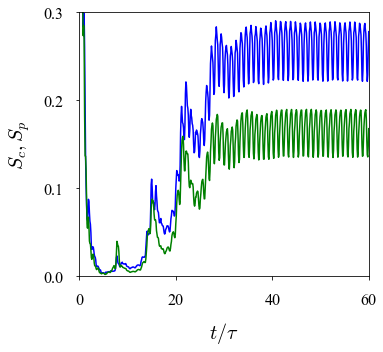

In [4]:
# all parameters
params = {
    'looper': {
        'plot': False,
        'X': {
            'var': 'mu',
            'min': 0.0,
            'max': 0.04,
            'dim': 11
        }
    },
    'solver': {
        'show_progress': True,
        'cache': True,
        'method': 'ode',
        'measure_type': 'qcm',
        'idx_mode_i': 1,
        'idx_mode_j': 3,
        'range_min': 0,
        'range_max': 601,
        't_min': 0,
        't_max': 600,
        't_dim': 6001
    },
    'system': {
        'E': 320,
        'g': 0.005, 
        'gamma': 0.005, 
        'kappa': 0.15, 
        'mu': 0.02,
        'n_b': 0,
        'omega_1': 1,
        'omega_2': 1.005
    },
    'plotter': {
        'type': 'lines',
        'x_label': '$t / \\tau$',
        'x_bound': 'both',
        'x_ticks': [0, 20, 40, 60],
        'v_label': '$S_{c}, S_{p}$',
        'y_colors': ['b', 'g'],
        'v_bound': 'both',
        'v_ticks': [0.0, 0.1, 0.2, 0.3] 
    }
}

# initialize system
system = System(params['system'])

# get complete synchronization
params['solver']['qcm_type'] = 'sync_complete'
M_0 = system.get_measure_dynamics(params['solver'], system.ode_func, system.ivc_func)
# get phase synchronization
params['solver']['qcm_type'] = 'sync_phase'
M_1 = system.get_measure_dynamics(params['solver'], system.ode_func, system.ivc_func)

# plotter
t_min = params['solver']['range_min']
t_max = params['solver']['range_max'] - 1
t_ss = (params['solver']['t_dim'] - 1) / params['solver']['t_max']
T = np.linspace(t_min / t_ss, t_max / t_ss, t_max - t_min + 1).tolist()
axes = {
    'X': T,
    'Y': {
        'var': 'M',
        'val': [0, 2]
    }
}
plotter = MPLPlotter(axes, params['plotter'])
_xs = [T, T]
_vs = [M_0, M_1]
plotter.update(xs=_xs, vs=_vs)
plotter.show(True, width=6.0)

### Figure 2b

MainProcess              INFO    2021-05-18 10:32:28.403: (qom.loopers.XLooper) ---------------------Looper Initialized-----------------	
MainProcess              INFO    2021-05-18 10:32:30.150: (qom.loopers.XLooper) ---------------------Values Obtained--------------------	
MainProcess              INFO    2021-05-18 10:32:30.151: (qom.loopers.XLooper) ---------------------Looper Initialized-----------------	
MainProcess              INFO    2021-05-18 10:32:31.940: (qom.loopers.XLooper) ---------------------Values Obtained--------------------	
MainProcess              INFO    2021-05-18 10:32:31.941: (qom.loopers.XLooper) ---------------------Looper Initialized-----------------	
MainProcess              INFO    2021-05-18 10:32:33.909: (qom.loopers.XLooper) ---------------------Values Obtained--------------------	


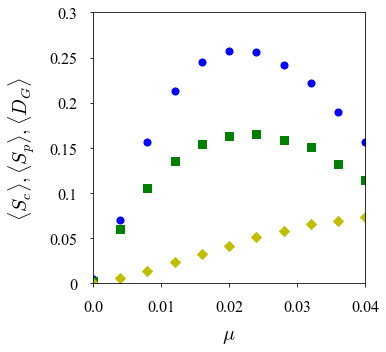

In [5]:
# all parameters
params = {
    'looper': {
        'plot': False,
        'X': {
            'var': 'mu',
            'min': 0.0,
            'max': 0.04,
            'dim': 11
        }
    },
    'solver': {
        'cache': True,
        'method': 'ode',
        'measure_type': 'qcm',
        'qcm_type': 'sync_phase',
        'idx_mode_i': 1,
        'idx_mode_j': 3,
        'range_min': 300,
        'range_max': 501,
        't_min': 0,
        't_max': 600,
        't_dim': 6001
    },
    'system': {
        'E': 320,
        'g': 0.005, 
        'gamma': 0.005, 
        'kappa': 0.15, 
        'mu': 0.0,
        'n_b': 0,
        'omega_1': 1,
        'omega_2': 1.005
    },
    'plotter': {
        'type': 'scatters',
        'x_label': '$\\mu$',
        'y_colors': ['b', 'g', 'y'],
        'y_sizes': [50, 50, 50],
        'y_styles': ['o', 's', 'D'],
        'v_label': '$\\langle S_{c} \\rangle, \\langle S_{p} \\rangle, \\langle D_{G} \\rangle$',
        'v_bound': 'both',
        'v_ticks': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    }
}

# initialize system
system = System(params['system'])

# get average complete synchronization
params['solver']['qcm_type'] = 'sync_complete'
S_c_avg = XLooper(func_measure_average, params).loop()['V']

# get average phase synchronization
params['solver']['qcm_type'] = 'sync_phase'
S_p_avg = XLooper(func_measure_average, params).loop()['V']

# get average Gaussian discord
params['solver']['qcm_type'] = 'discord'
looper = XLooper(func_measure_average, params)
D_G_avg = looper.loop()['V']

# plotter
X = looper.axes['X']['val']
axes = {
    'X': X,
    'Y': {
        'var': 'QCM',
        'val': ['$\\langle S_{c} \\rangle$', '$\\langle S_{p} \\rangle$', '$\\langle D_{G} \\rangle$'],
    }
}
plotter = MPLPlotter(axes, params['plotter'])
plotter.update(xs=[X, X, X], vs=[S_c_avg, S_p_avg, D_G_avg])
plotter.show(True, width=6.0)